In [1]:
# import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Bakcpack:
#     - human eye: 15 m
#     - Distance max: 7.42 m
#     - Distance where detects constantly: 6.42 m
# Drill:
#     - human eye: 10 m
#     - Distance max: 2.45 m
#     - Distance where detects constantly: 0.5 m 
# Vent:
#     - human eye: 12 m
#     - Distance max: 8.5 m
#     - Distance where detects constantly: 8.5 m 
# Rope:
#     - human eye: 10 m
#     - Distance max: 2.04 m
#     - Distance where detects constantly: 1.42 m 
# Helmet:
#     - human eye: 10 m
#     - Distance max: 3.06 m
#     - Distance where detects constantly: 2.3 m
# Fire extinsguisher:
#     - human eye: 10 m
#     - Distance max: 7.65 m
#     - Distance where detects constantly: 7.15 m
# Survivor:
#     - human eye: 10 m
#     - Distance max: 11.2 m
#     - Distance where detects constantly: 11.2 m
# Cellphone:
#     - human eye: 10 m
#     - Distance max: 3.4 m
#     - Distance where detects constantly: 1.52 m

det_ranges = {
    "Backpack": {"min": 1.0, "max": 7.42, "const": 6.42},
    "Drill": {"min": 0.3, "max": 2.45, "const": 0.5},
    "Vent": {"min": 1.25, "max": 8.5, "const": 8.5},
    "Rope": {"min": 0.4, "max": 2.04, "const": 1.42},
    "Helmet": {"min": 0.8, "max": 3.06, "const": 2.3},
    "Fire extinsguisher": {"min": 1.2, "max": 7.65, "const": 7.15},
    "Survivor": {"min": 2.2, "max": 11.2, "const": 11.2},
    "Cellphone": {"min": 0.2, "max": 3.4, "const": 1.52}
}

In [3]:
def get_step_signal(t, max_dist):
    return t < max_dist

def get_linear_signal(t, const_dist, max_dist):
    k = -1.0 / (max_dist - const_dist + 1e-3)
    b = -k * max_dist

    y = k*t + b
    y = torch.minimum(y, 1.0)
    y = torch.maximum(y, 0.0)
    return y

def get_trap_signal(t, const_dist, max_dist, min_dist=0.25):       
    k = -1.0 / (max_dist - const_dist + 1e-3)
    b = -k * max_dist

    y = k*t + b
    y = torch.minimum(y, torch.tensor(1.0))
    y = torch.maximum(y, torch.tensor(0.0))
    
    y[t < min_dist] = t[t < min_dist] / min_dist
    return y

def get_gaus_signal(t, mu, sigma):
    return torch.exp(-(t - mu) ** 2 / sigma ** 2)

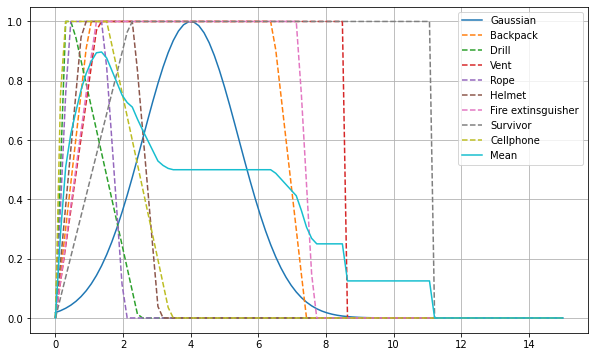

In [4]:
dist = torch.linspace(0.0, 15.0, 100)

mu, sigma = 4.0, 2.0
gaus = get_gaus_signal(dist, mu, sigma)

signal_sum = 0.0

plt.figure(figsize=(10, 6))
plt.plot(dist, gaus, label="Gaussian")

for artifact in det_ranges:
#     signal = get_step_signal(dist, det_ranges[artifact]["max"])
#     signal = get_linear_signal(dist, det_ranges[artifact]["const"], det_ranges[artifact]["max"])
    signal = get_trap_signal(dist, det_ranges[artifact]["const"],
                             det_ranges[artifact]["max"],
                             det_ranges[artifact]["min"])
    signal_sum += signal
    plt.plot(dist, signal, '--', label=artifact)
    
signal_sum /= len(det_ranges)
plt.plot(dist, signal_sum, label='Mean')
plt.legend()
plt.grid()

### Gaussians for each class

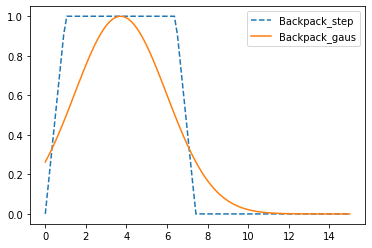

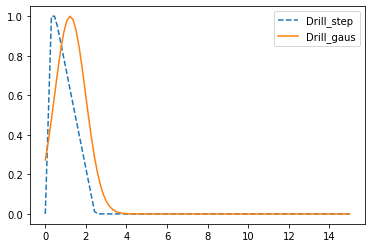

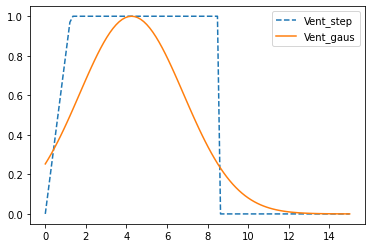

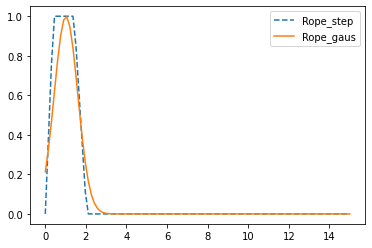

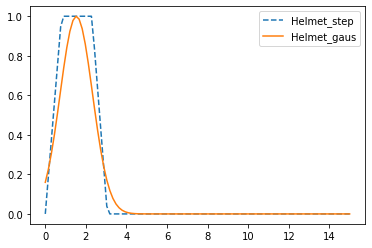

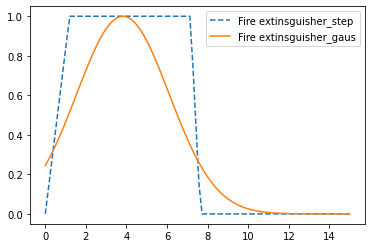

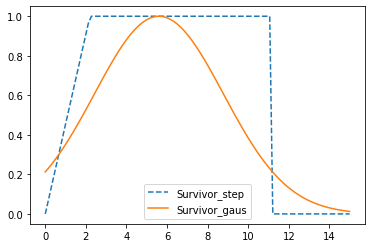

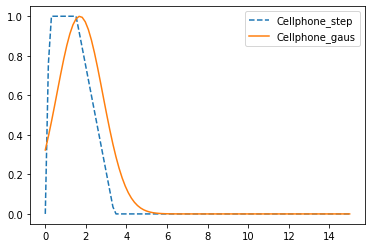

In [5]:
gs = []
for artifact in det_ranges:
    det_ranges[artifact]["mu"] = 0.5*(det_ranges[artifact]["max"])
    det_ranges[artifact]["std"] = 0.5*(det_ranges[artifact]["max"] - det_ranges[artifact]["min"])
    trap = get_trap_signal(dist, det_ranges[artifact]["const"],
                             det_ranges[artifact]["max"],
                             det_ranges[artifact]["min"])
    gaus = get_gaus_signal(dist, det_ranges[artifact]["mu"], det_ranges[artifact]["std"])
    gs.append(gaus[None])

    plt.figure()
    plt.plot(dist, trap, '--', label=artifact+'_step')
    plt.plot(dist, gaus, label=artifact+'_gaus')
    plt.legend()
    plt.show()

In [6]:
torch.cat(gs, dim=0).shape

torch.Size([8, 100])